# Smoothing

There are many options to use smoothing for probabilistic IVP solving.
Here is how.


In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from probdiffeq import ivpsolve, adaptive
from probdiffeq.impl import impl
from probdiffeq.util.doc_util import notebook
from probdiffeq.solvers import calibrated, solution
from probdiffeq.taylor import autodiff
from probdiffeq.solvers.strategies.components import corrections, priors
from probdiffeq.solvers.strategies import filters, smoothers, fixedpoint

In [2]:
plt.rcParams.update(notebook.plot_config())

if not backend.has_been_selected:
    backend.select("jax")  # ivp examples in jax

config.update("jax_platform_name", "cpu")

In [3]:
impl.select("isotropic", ode_shape=(2,))

In [4]:
f, u0, (t0, t1), f_args = ivps.lotka_volterra(time_span=(0.0, 10.0))


@jax.jit
def vf(*ys, t):
    return f(*ys, *f_args)


tcoeffs = autodiff.taylor_mode_scan(lambda y: vf(y, t=t0), (u0,), num=4)

## Terminal-value simulation

If you are interested in the terminal value of the ODE solution, you can use filters and smoothers interchangeably.
But be aware that a smoother computes more intermediate values than a filter, so filters are more efficient here.

In [5]:
ibm = priors.ibm_adaptive(num_derivatives=4)
ts0 = corrections.ts0()

ekf0 = calibrated.mle(filters.filter_adaptive(ibm, ts0))
init = ekf0.initial_condition(tcoeffs, output_scale=1.0)
ekf0sol = ivpsolve.simulate_terminal_values(
    vf,
    init,
    t0=t0,
    t1=t1,
    dt0=0.1,
    adaptive_solver=adaptive.adaptive(ekf0),
)
print(ekf0sol.t, ekf0sol.u)

10.0 [11.866332   2.6325293]


## Traditional simulation

If you are used to calling traditional solve() methods, use one a conventional smoother (i.e. not the fixed-point smoother).

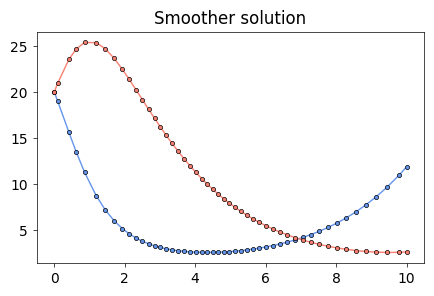

In [6]:
eks0 = calibrated.mle(smoothers.smoother_adaptive(ibm, ts0))
init = eks0.initial_condition(tcoeffs, output_scale=1.0)
eks0sol = ivpsolve.solve_and_save_every_step(
    vf,
    init,
    t0=t0,
    t1=t1,
    dt0=0.1,
    adaptive_solver=adaptive.adaptive(eks0),
)

plt.subplots(figsize=(5, 3))
plt.title("Smoother solution")
plt.plot(eks0sol.t, eks0sol.u, ".-")
plt.show()

If you like, compute the solution on a dense grid after solving.

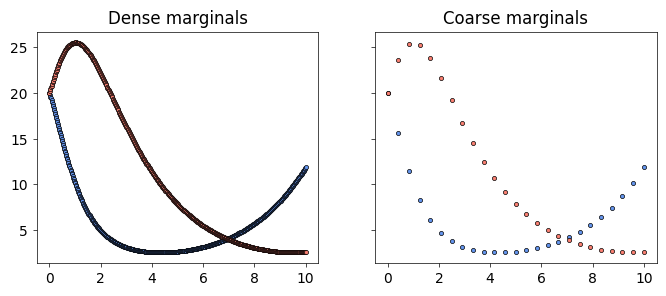

In [7]:
ts_dense = jnp.linspace(
    t0 + 1e-4, t1 - 1e-4, num=500, endpoint=True
)  # must be off-grid
dense, _ = solution.offgrid_marginals_searchsorted(
    ts=ts_dense, solution=eks0sol, solver=eks0
)

ts_coarse = jnp.linspace(
    t0 + 1e-4, t1 - 1e-4, num=25, endpoint=True
)  # must be off-grid
coarse, _ = solution.offgrid_marginals_searchsorted(
    ts=ts_coarse, solution=eks0sol, solver=eks0
)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 3))


ax1.set_title("Dense marginals")
ax1.plot(ts_dense, dense, ".")

ax2.set_title("Coarse marginals")
ax2.plot(ts_coarse, coarse, ".")
plt.show()

## Checkpoint simulation

If you know in advance that you like to have the solution at a pre-specified set of points only,
use the solve_and_save_at function together with a fixed-point smoother.


    !!! "Warning: EXPERIMENTAL feature!" !!!



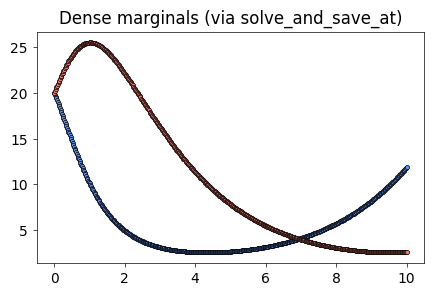

In [8]:
ekfp0 = calibrated.mle(fixedpoint.fixedpoint_adaptive(ibm, ts0))
init = eks0.initial_condition(tcoeffs, output_scale=1.0)
fixptsol = ivpsolve.solve_and_save_at(
    vf,
    init,
    save_at=ts_dense,  # reuse from above
    dt0=0.1,
    adaptive_solver=adaptive.adaptive(ekfp0),
)

plt.subplots(figsize=(5, 3))
plt.title("Dense marginals (via solve_and_save_at)")
plt.plot(fixptsol.t, fixptsol.u, ".-")
plt.show()